This notebook uses Gaussian processes to find the distribution of functions that fit a toy dataset, both incorporating correlations between data points and treating each as independent. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

import sys
sys.path.append('../')
from GP import GaussianProcessRegressor

Define some toy data combining multiple perfectly correlated datasets with overlapping energy ranges. x denotes the measured values at each energy, each with some error bar. Each data point has 10% total error. There must be a relatively large number of data points to get a degenerate covariance matrix after the kernel is added -- this is a minimal example of such a dataset. 

In [2]:
datasets = 3
n = 5
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

x = np.zeros(N)                 # All x
y = np.zeros(N)                # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = 0.5-np.random.rand(n) + energies                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        x[index] = energies[j]
        y[index] = values[j]
        total_errors[index] = s[j] 
        systematic_errors[index] = s[j]
    dataset_sizes[i] = n


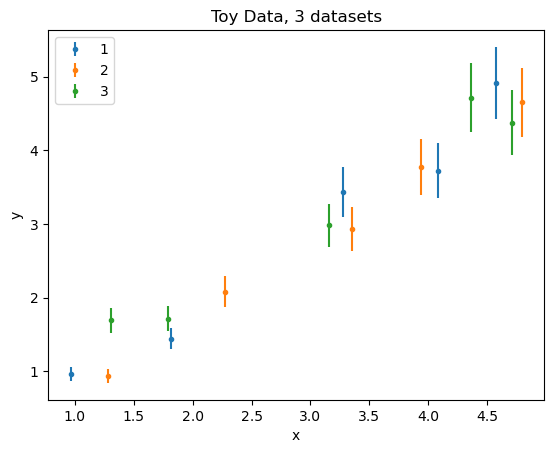

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot the toy data

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'Toy Data, {datasets} datasets')
plt.show()
plt.clf()

An adapted Gaussian process regression code from scikit-learn that incorporates degeneracies amongst the data is used.

In [4]:
magnitude = 1                             # Initial values for kernel hyperparameters, which get set by extremizing the log-likelihood
length_scale = 1
kernel = ConstantKernel(magnitude) * RBF(length_scale) 
correlated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total_errors, systematic_errors, dataset_sizes)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total_errors)

/opt/anaconda3/envs/jaxpy311/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/jaxpy311/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


While the uncorrelated case produces one large eigenvalue with the rest around 0.1-0.01, the correlated case has an effective rank much lower than the number of columns. (This includes )

In [5]:
lower_bound = 1e-5

uncorrelated_eigvals = eigvals(uncorrelated_K11)
print('Uncorrelated GP upper left covariance eigenvalues:\n', uncorrelated_eigvals)
print('Effective rank: ', np.sum(uncorrelated_eigvals > lower_bound))

correlated_eigvals = eigvals(correlated_K11)
print('\nCorrelated GP upper left covariance eigenvalues:\n', correlated_eigvals)
print('Effective rank: ', np.sum(correlated_eigvals > lower_bound))

Uncorrelated GP upper left covariance eigenvalues:
 [2.68016755e+02+0.j 1.39830844e+01+0.j 5.21128886e-01+0.j
 9.60752506e-02+0.j 1.40159046e-01+0.j 1.53483299e-01+0.j
 1.74744505e-01+0.j 2.18345992e-01+0.j 4.84449293e-01+0.j
 4.59814627e-01+0.j 4.46861341e-01+0.j 3.22042031e-01+0.j
 2.95526798e-01+0.j 3.64081528e-01+0.j 3.74991554e-01+0.j]
Effective rank:  15

Correlated GP upper left covariance eigenvalues:
 [5.28146462e-01+0.00000000e+00j 5.60857252e-01+0.00000000e+00j
 4.97274723e-01+0.00000000e+00j 2.59659739e-05+0.00000000e+00j
 1.00000864e-10+0.00000000e+00j 1.00000049e-10+0.00000000e+00j
 9.99999643e-11+8.70577761e-18j 9.99999643e-11-8.70577761e-18j
 9.99999736e-11+0.00000000e+00j 9.99999851e-11+1.03946493e-17j
 9.99999851e-11-1.03946493e-17j 1.00000014e-10+7.03283146e-18j
 1.00000014e-10-7.03283146e-18j 1.00000004e-10+0.00000000e+00j
 1.00000006e-10+0.00000000e+00j]
Effective rank:  4


In [6]:
# Get GP posterior

num_test = 300
x_test = np.linspace(0.5, n+0.5, num_test)
correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)

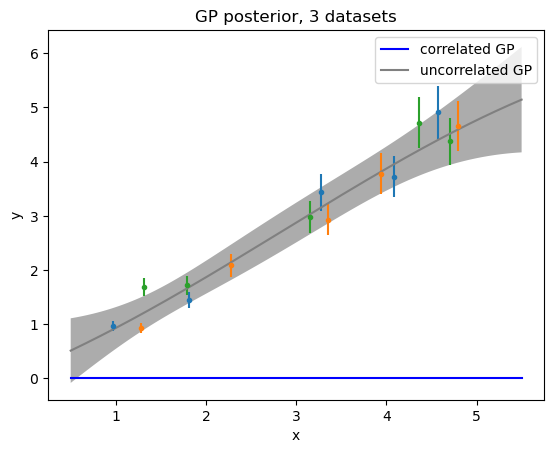

In [7]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

plt.plot(x_test, correlated_mean, color='blue', label='correlated GP')
plt.fill_between(x_test, correlated_mean - 2*correlated_std, correlated_mean + 2*correlated_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'GP posterior, {datasets} datasets')
plt.show()

This analysis is repeated with only 1 correlated dataset.

In [39]:
x = np.zeros(n)
y = np.zeros(n)
total_errors = np.zeros(n)
systematic_errors = np.zeros(n)
dataset_sizes = np.zeros(datasets)

energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
values = 0.5-np.random.rand(n) + energies

s = percent_error*np.abs(values)

for j in range(n):
    x[j] = energies[j]
    y[j] = values[j]
    total_errors[j] = s[j] 
    systematic_errors[j] = s[j]
dataset_sizes[i] = n

In [40]:
correlated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total_errors, systematic_errors, dataset_sizes)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total_errors)

correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)

In [41]:
correlated_K11

array([[14.53045798, 11.49233219,  6.83871854,  5.02835107,  2.20565435],
       [11.49233219, 14.57543081, 12.59621624, 10.84255273,  6.63836702],
       [ 6.83871854, 12.59621624, 14.61279862, 14.24351076, 11.34358318],
       [ 5.02835107, 10.84255273, 14.24351076, 14.63351089, 13.03388202],
       [ 2.20565435,  6.63836702, 11.34358318, 13.03388202, 14.75172187]])

In [36]:
print('Uncorrelated GP upper left covariance eigenvalues:\n', eigvals(uncorrelated_K11))
print('\nCorrelated GP upper left covariacnce eigenvalues:\n', eigvals(correlated_K11))

Uncorrelated GP upper left covariance eigenvalues:
 [81.30871239+0.j  4.58716433+0.j  0.44654296+0.j  0.29679314+0.j
  0.2501315 +0.j]

Correlated GP upper left covariacnce eigenvalues:
 [9.55526792+0.j 9.05645288+0.j 9.05645288+0.j 9.05645288+0.j
 9.05645288+0.j]


The effect is not as pronounced as before (note the eigenvalues have not decayed to near 0 with only 5 total data points). However, the correlated case still shows a mean driven below the input data points. Note that since 10% total error is used, the smallest data point has the smallest error.

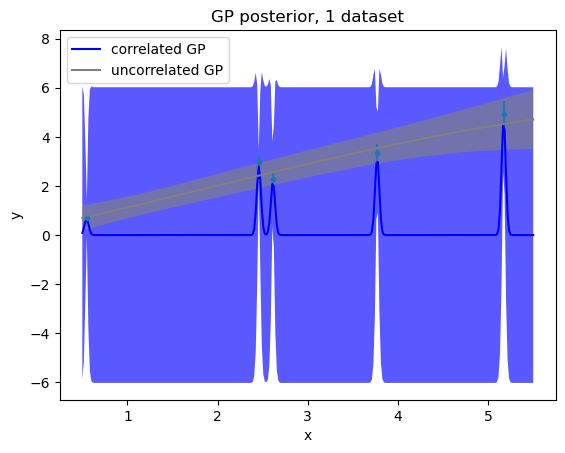

In [37]:
plt.errorbar(x, y, percent_error*np.abs(x), fmt='.')

plt.plot(x_test, correlated_mean, color='blue', label='correlated GP')
plt.fill_between(x_test, correlated_mean - 2*correlated_std, correlated_mean + 2*correlated_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title('GP posterior, 1 dataset')
plt.show()

# Cara Scratch

In [8]:
datasets = 3
n = 5
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

x = np.zeros(N)                 # All x
y = np.zeros(N)                # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = 0.5-np.random.rand(n) + energies                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        x[index] = energies[j]
        y[index] = values[j]
        total_errors[index] = s[j] 
        systematic_errors[index] = s[j]
    dataset_sizes[i] = n


## example with matern kernel and diagonal covariance matrix

In [33]:
def matern_kernel(target_array,time_array,sigma,tau):
    delta_t = np.abs(np.expand_dims(target_array, axis = 1) - time_array) # shape will be 3 x 2 if length of first array is 3 and length of second array is 2
    return sigma**2*(1+np.sqrt(3)*delta_t/tau)*np.exp(-np.sqrt(3)*delta_t/tau)

def linear_kernel(target_array, time_array, sigma, tau):
    return sigma**2 * (target_array- tau) * (time_array - tau)

def kernel_func(target_array,time_array,sigma_matern,tau_matern,sigma_linear,tau_linear):
    return matern_kernel(target_array,time_array,sigma_matern,tau_matern) + linear_kernel(target_array, time_array, sigma_linear, tau_linear)

In [38]:
sigma=1
tau = 1


kernel_matrix = matern_kernel(x,x,sigma,tau)

# kernel = ConstantKernel(magnitude) * RBF(length_scale) 
# correlated_gp = GaussianProcessRegressor(kernel=kernel)
# uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

# correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total_errors, systematic_errors, dataset_sizes)
# uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total_errors)

In [11]:
target_times = np.linspace(0.1,7,int(7/.1))
k_star= matern_kernel(target_times,x,sigma,tau)

In [12]:
covariance = np.diag(total_errors**2)
ystar = np.dot(k_star,np.linalg.solve(kernel_matrix+covariance,y))

variance = matern_kernel(target_times,target_times,sigma,tau) - \
np.dot(matern_kernel(target_times,x,sigma,tau),\
       np.linalg.solve(matern_kernel(x,x,sigma,tau)+covariance,\
               np.transpose(matern_kernel(target_times,x,sigma,tau))))
sigmas_squared = np.diag(variance,k=0)

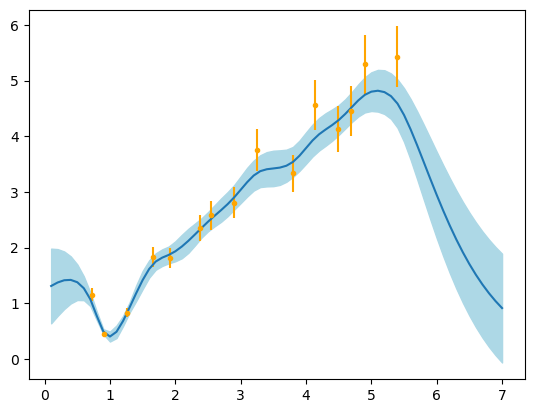

In [13]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')

# plt.errorbar(data[0], data[-1], yerr=data[1],
#              color="k", marker="o", alpha=0.5,zorder=1)
plt.plot(target_times, ystar)
# plot one sigma variance at each point
plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')

## matern kernel and 0 covariance

In [14]:
covariance = 0
ystar = np.dot(k_star,np.linalg.solve(kernel_matrix+covariance,y))

variance = matern_kernel(target_times,target_times,sigma,tau) - \
np.dot(matern_kernel(target_times,x,sigma,tau),\
       np.linalg.solve(matern_kernel(x,x,sigma,tau)+covariance,\
               np.transpose(matern_kernel(target_times,x,sigma,tau))))
sigmas_squared = np.diag(variance,k=0)

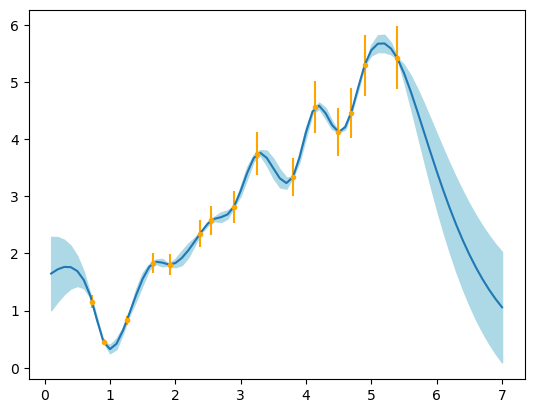

In [15]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')

# plt.errorbar(data[0], data[-1], yerr=data[1],
#              color="k", marker="o", alpha=0.5,zorder=1)
plt.plot(target_times, ystar)
# plot one sigma variance at each point
plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')

## matern kernel, artificial covariance with large off-diagonal entries

In [16]:
covariance = np.diag(total_errors**2)

for i in range(np.shape(covariance)[0]):
    covariance[i][i] *= 10

covariance[1][1]=0
covariance[7][7]=0
covariance[3][3]=0

for i in range(np.shape(covariance)[0]):
    covariance[i][i-1] += 1e2
    covariance[i][(i+1)%np.shape(covariance)[0]] += 1e3

In [17]:
covariance

array([[1.33059454e-01, 1.00000000e+03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+02],
       [1.00000000e+02, 0.00000000e+00, 1.00000000e+03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+02, 1.40642252e+00, 1.00000000e+03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+02, 0.00000000e+00,
        1.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+0

In [18]:
# covariance = np.tile(correlated_K11,(3,3))

sigma=1e-4
tau=1e-1
kernel_matrix = matern_kernel(x,x,sigma,tau)
print(np.linalg.solve(kernel_matrix+covariance,y))
ystar = np.dot(k_star,np.linalg.solve(kernel_matrix+covariance,y))

# variance = matern_kernel(target_times,target_times,sigma,tau) - \
# np.dot(matern_kernel(target_times,x,sigma,tau),\
#        np.linalg.solve(matern_kernel(x,x,sigma,tau)+covariance,\
#                np.transpose(matern_kernel(target_times,x,sigma,tau))))
# sigmas_squared = np.diag(variance,k=0)

[4.19944682e-03 8.32828590e-04 1.38589625e-03 3.66499801e-03
 3.98901675e-03 5.05310681e-03 5.37255792e-05 1.84117234e-03
 2.80331530e-03 4.37389706e-03 5.00270798e-03 3.89866127e-04
 1.33271655e-03 2.53847649e-03 3.20126629e-03]


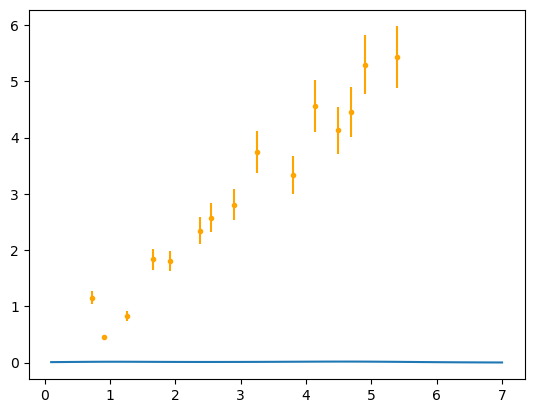

In [19]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')
plt.plot(target_times, ystar)
# plot one sigma variance at each point
# plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')

## RBF kernel

In [20]:
def scaled_RBF_kernel(target_array,time_array,sigma,tau):
    return tau*np.exp(-np.abs(np.expand_dims(target_array, axis = 1) - time_array)**2/(2*sigma**2))

In [21]:
sigma = 1
tau = 1

kernel_matrix = scaled_RBF_kernel(x,x,sigma,tau)
target_times = np.linspace(0.1,7,int(7/.1))
k_star= scaled_RBF_kernel(target_times,x,sigma,tau)

In [22]:
covariance = np.diag(total_errors**2)
ystar = np.dot(k_star,np.linalg.solve(kernel_matrix+covariance,y))

variance = scaled_RBF_kernel(target_times,target_times,sigma,tau) - \
np.dot(scaled_RBF_kernel(target_times,x,sigma,tau),\
       np.linalg.solve(scaled_RBF_kernel(x,x,sigma,tau)+covariance,\
               np.transpose(scaled_RBF_kernel(target_times,x,sigma,tau))))
sigmas_squared = np.diag(variance,k=0)

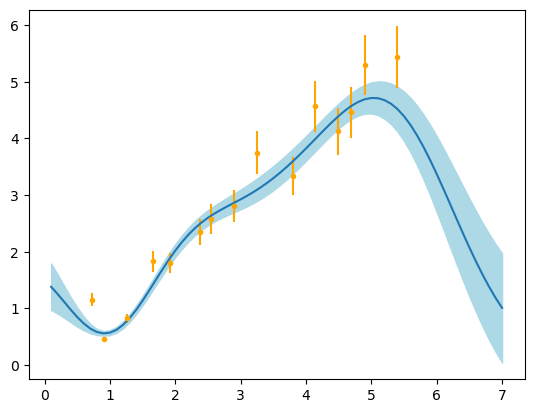

In [23]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')
plt.plot(target_times, ystar)
plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')

In [24]:
covariance = np.diag(total_errors**2)

for i in range(np.shape(covariance)[0]):
    covariance[i][i] *= 10

covariance[1][1]=0
covariance[7][7]=0
covariance[3][3]=0

for i in range(np.shape(covariance)[0]):
    covariance[i][i-1] += 1e-2
    covariance[i][(i+1)%np.shape(covariance)[0]] += 1e-10

In [25]:
# covariance = np.tile(correlated_K11,(3,3))
sigma=1
tau=20
ystar = np.dot(k_star,np.linalg.solve(kernel_matrix+covariance,y))

variance = scaled_RBF_kernel(target_times,target_times,sigma,tau) - \
np.dot(scaled_RBF_kernel(target_times,x,sigma,tau),\
       np.linalg.solve(scaled_RBF_kernel(x,x,sigma,tau)+covariance,\
               np.transpose(scaled_RBF_kernel(target_times,x,sigma,tau))))
sigmas_squared = np.diag(variance,k=0)

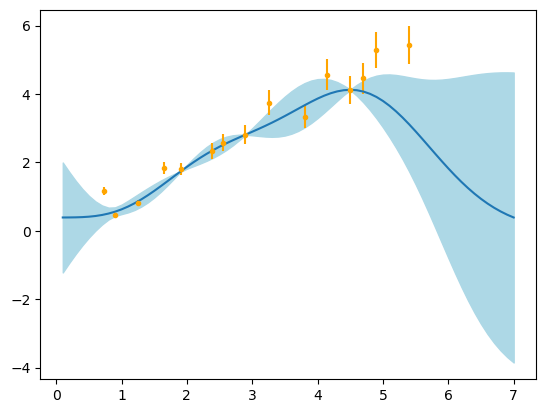

In [26]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')
plt.plot(target_times, ystar)
plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')

## matern + linear

In [363]:
def matern_kernel(target_array,time_array,sigma,tau):
    delta_t = np.abs(np.expand_dims(target_array, axis = 1) - time_array) # shape will be 3 x 2 if length of first array is 3 and length of second array is 2
    return sigma**2*(1+np.sqrt(3)*delta_t/tau)*np.exp(-np.sqrt(3)*delta_t/tau)

def linear_kernel(target_array, time_array, sigma, tau, A):
    return A + sigma**2*(np.expand_dims(target_array, axis = 1)- tau) * (time_array - tau)

def kernel_func(target_array,time_array,sigma_matern,tau_matern,sigma_linear,tau_linear, A):
    return matern_kernel(target_array,time_array,sigma_matern,tau_matern) + \
    linear_kernel(target_array, time_array, sigma_linear, tau_linear, A)

In [364]:
covariance = np.diag(total_errors**2)

for i in range(np.shape(covariance)[0]):
    covariance[i][i] *= 10

covariance[1][1]=0
covariance[7][7]=0
covariance[3][3]=0

for i in range(np.shape(covariance)[0]):
    covariance[i][i-1] += 1e2
    covariance[i][(i+1)%np.shape(covariance)[0]] += 1e3

In [382]:
sigma_matern = 1e1
tau_matern = 1e-1

sigma_linear = 1e3
tau_linear =  1e-3
A=1


kernel_matrix = kernel_func(x,x,sigma_matern,tau_matern,sigma_linear,tau_linear, A)

target_times = np.linspace(0.1,7,int(7/.1))
k_star= kernel_func(target_times,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A)

ystar = np.dot(k_star,np.linalg.solve(kernel_matrix+covariance,y))

variance = kernel_func(target_times,target_times,sigma_matern,tau_matern,sigma_linear,tau_linear,A) - \
np.dot(kernel_func(target_times,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A),\
       np.linalg.solve(kernel_func(x,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A)+covariance,\
               np.transpose(kernel_func(target_times,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A))))
sigmas_squared = np.diag(variance,k=0)

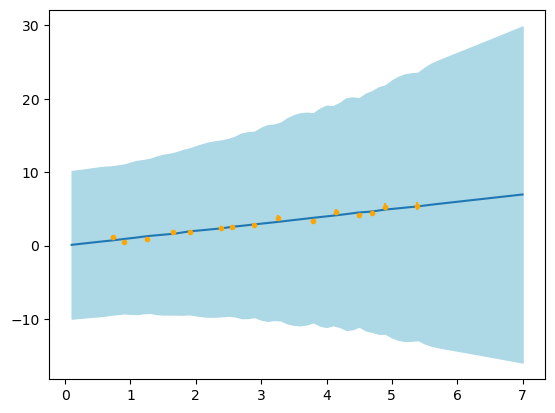

In [384]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')
plt.plot(target_times, ystar)
plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')
# plt.ylim([1,7])

In [390]:
sigma_matern = 1e1
tau_matern = 1e-1

sigma_linear = 1e3
tau_linear =  1e-3
A=1


kernel_matrix = kernel_func(x,x,sigma_matern,tau_matern,sigma_linear,tau_linear, A)

target_times = np.linspace(0.1,7,int(7/.1))
k_star= kernel_func(target_times,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A)

piece = np.linalg.lstsq(kernel_matrix+covariance,y,rcond=1e-10)[0]
ystar = np.dot(k_star,piece)

variance = kernel_func(target_times,target_times,sigma_matern,tau_matern,sigma_linear,tau_linear,A) - \
np.dot(kernel_func(target_times,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A),\
       np.linalg.solve(kernel_func(x,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A)+covariance,\
               np.transpose(kernel_func(target_times,x,sigma_matern,tau_matern,sigma_linear,tau_linear,A))))
sigmas_squared = np.diag(variance,k=0)

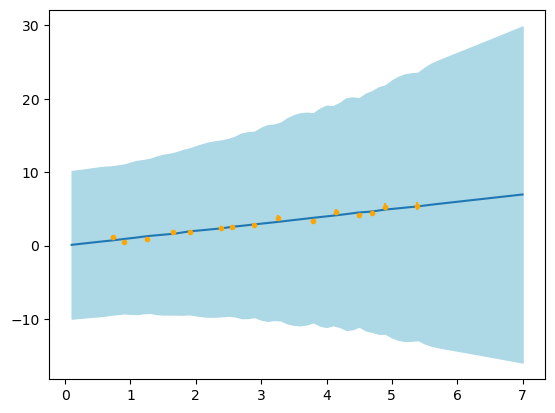

In [391]:
plt.errorbar(x, y, percent_error*np.abs(y), fmt='.',color='orange')
plt.plot(target_times, ystar)
plt.fill_between(target_times,ystar+np.sqrt(sigmas_squared),ystar-np.sqrt(sigmas_squared),color='lightblue')
# plt.ylim([1,7])